In [ ]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np
import scipy.stats as st
import time

In [ ]:
#Defining the input axes
# Note: the boundaries for the control actions are the actuation constraints imposed by the physics of the robots

control_space_size = 3  # Three possible inputs for each control axis
# la u è discretizzata su 3 valori

U_space_1 = np.array(np.linspace((-0.5),(0.5),control_space_size)) 
U_space_2 = np.array(np.linspace((-0.5),(0.5),control_space_size))

# E' come se avessimo uno spazio planare sul quale fornire le azioni di controllo u1 u2

time_step = 0.033 # Robotarium time-step (from the documentation)

In [31]:
# This function performs a "model" step using the documented dynamics
# Note: from the viewpoint of the controller the dynamics is not necesarily known
def model_step(x,velocities,time_step):
    poses = np.zeros((2,1))
    # Update pose of the robots
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    return(poses)

#Get the value of a Gaussian pf at a given point *****?
# This function is used to evaluate the pf at a given point (x,y) given the mean and covariance of the Gaussian 
def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf


##### WP0: formalize the control problem #####

# Task: reverse engineer the cost function used by the robots. What is the problem formulation? 
#      Is the one below a good cost for the task? Create a heatmap to visualize the cost 

# This function computes the cost of a state given the goal and obstacle points (the cost is a sum of Gaussians)
def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar) # Questo dipende dalle gaussiane mediate negli ostacoli,
        # come se avessimo che più ci avviciniamo all'ostacolo più aumenti il costo
        
        #### AGGIUNTO NOI ####
        # gauss_sum += 10*my_logpdf(state[:2],obs_points[:2,i],covar) 
        

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    
    #### AGGIUNTO NOI ####
    # cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
    #             + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
    #             + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    return(cost)

##### WP1: fill-in the code for the function below.
#         The function needs to return the optimal action sampled from the optimal policy.
#         The action is used in the simulation loop #####

def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):
                # Task: what do the next three lines do?
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)

                # Queste tre linee di codice calcolano il prossimo stato, a partire da una delle 9 azioni scandite
                # dai cicli for, e creano una multivariata normale centrata nel prossimo stato con covarianza data

                # Task: what do the next two lines do?
                N_samples = 20
                next_sample = f.rvs(N_samples)
                # Queste due linee di codice campionano 20 campioni dalla distribuzione calcolata precedentemente

                # Task: what do the next three lines do?
                cost=0
                for k in range(N_samples):
                    cost+=state_cost(next_sample[k,:],goal_points,obs_points)/N_samples
                    # print("next_sample[k,:]: " + str(next_sample[k,:]))
                # Calcoliamo il costo medio dei campioni secondo la funzione state_cost, si tratta di calcolare
                # l'expected value della formula per la policy

                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
                # print("entropy: " + str(f.entropy()))
                # print("next state: " + str(next_state))
                # print("cost: " + str(cost))

                log_DKL = np.exp(-cost+f.entropy())*target_pf

                # la log_DKL è uguale, secondo formulazione, a np.exp(-DKL-costoatteso), il costo atteso lo abbiamo calcolato
                # al punto precedente, mentre la DKL(f||g), dato che g è uniforme, diventa semplicemente l'entropia. (Formula 12.11)
                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)

        # Task: obtain the normalized pf (call the variable pf)
        pf = pf/S2

        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

In [ ]:
# this function is used to plot the heatmap of the cost function
def plot_heatmap(goal_points,obs_points):
    x_min = -1.5
    x_max = 1.5
    y_min = -1
    y_max = 1
    x_range = np.linspace(x_min,x_max,100)
    y_range = np.linspace(y_min,y_max,100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            Z[i,j] = state_cost(np.array([X[i,j],Y[i,j]]),goal_points,obs_points)
    plt.pcolormesh(X,Y,Z)
    plt.colorbar()
    plt.scatter(goal_points[0],goal_points[1],c='r')
    plt.scatter(obs_points[0,:],obs_points[1,:],c='k')
    plt.show()

/tmp/ipykernel_1896/3720312835.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j] = state_cost(np.array([X[i,j],Y[i,j]]),goal_points,obs_points)


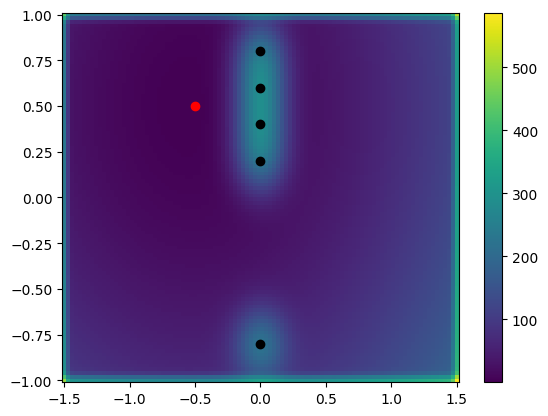

In [32]:
# Define goal and obstacle points
# goal_points = np.array(np.mat('-1.4; -0.8; 0')) # Da traccia
# goal_points = np.array(np.mat('0.5; 0.9; 0')) # test
goal_points = np.array(np.mat('-0.5; 0.5; 0')) # test

obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))
# obs_points = np.array(np.mat('-0.5 -0.5 -0.5 -0.5 0.9; 0.2 0.4 0.6 0.8 0.9; 0 0 0 0 0'))

# Plot the heatmap of the cost function
plot_heatmap(goal_points,obs_points)

In [ ]:
#WP2: Simulate (4 experiments) and visualize each robot's trajectory

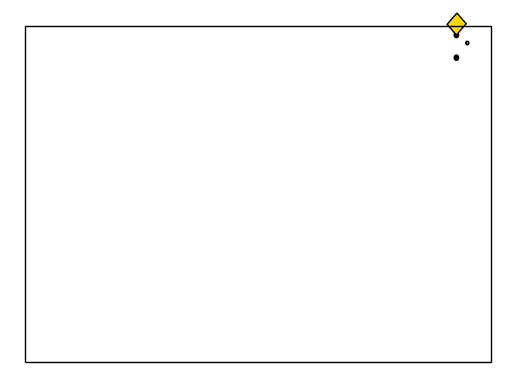

/tmp/ipykernel_1896/2326679038.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [36]:
# Instantiate Robotarium object
N = 1 #Amount of robots per simulation
# Initial conditions of the robot for 4 experiments
# initial_conditions = [np.array(np.mat('1.4; 0.9; 0')),np.array(np.mat('0.2; 0.9; 0')),np.array(np.mat('1.2; -0.5; 0')),np.array(np.mat('-1; 0.9; 0'))] #Initial pose of the robots
# Lo stato del robot è (x,y,theta), theta è l'angolo di orientamento del robot
# initial_conditions = [np.array(np.mat('0;0.9; 3.14')),np.array(np.mat('0;-0.9; 3.14')),np.array(np.mat('1.4;-0.25; 0')),np.array(np.mat('0;0.5; 0'))] #Initial pose of the robots
initial_conditions = [np.array(np.mat('1.4; 0.9; 0'))]
N_experiment = 1
# X_si is going to be two-dimensional state history
X_Si = [0]*N_experiment
# D_Xi is going to be two-dimensional inputs history
D_Xi = [0]*N_experiment

# This first for loop creates the initial conditions
for I in range(N_experiment):

    X_si = []
    D_xi = []

    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

    # Create mapping from the control inputs to the actual velocity commands to the unicycle
    # Note: this is a very practical situation (robots often provide transformation functions to low level commands)
    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion() #Converts single integrator inputs to unicycle inputs (low-level controller)
    _, uni_to_si_states = create_si_to_uni_mapping()
    
    # define x initially
    x = r.get_poses()
    # print("x: " + str(x))
    x_si = uni_to_si_states(x)

    # Plotting Parameters
    CM = np.random.rand(N+10,3) # Random Colors
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    # Create Goal Point Markers
    #Text with goal identification
    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    #Plot text for caption
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]

    #Text with goal identification
    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    #Plot text for caption
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]

    r.step()

    # While the robot is away from the objective ...
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):
    # i=0
    # while(i<10000):

        # Get poses of agents
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        #Add to the dataset
        X_si.append(x_si)

        # The lines below define the pdf of the robot 
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
        x_sample = x_pdf.rvs() #Noisy state
        
        #### Aggiunto noi
        # print("NUOVO STEP:")
        # print("x_si: " + str(x_si))
        # print("x: " + str(x))
        # print("x_sample: " + str(x_sample))

        # This is about plotting
        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Task: compute the action from the policy. Call the variable dxi: 
        # this is the action sampled from the optimal solution to the control problem
        dxi = Control_step(x_sample,U_space_1,U_space_2,goal_points,obs_points) 

        # print("dxi: " + str(dxi[0]))
        D_xi.append(dxi)

        # Transform single integrator velocity commands to unicycle inputs (low level controller)
        dxu = si_to_uni_dyn(dxi, x)
        
        # print("dxu: " + str(dxu))
        # Set the velocities inputs
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()
        # print("step: " + str(i))
        # i+=1
        
    D_Xi[I] = D_xi
    X_Si[I] = X_si

    #Call at end of script to print debug information and for your script to run on the Robotarium server properly
    r.call_at_scripts_end()

In [ ]:
XX = X_Si
UU = D_Xi

In [ ]:
#Prepare data for plotting
X = []
X_plot = []
U = []
U_plot = []

for i in range(len(XX)):
    X.append(np.array(XX[i]))
    X_plot.append(np.array(XX[i]))

X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

U = []
for i in range(len(UU)):
    U.append(np.array(UU[i]))
    U_plot.append(np.array(UU[i]))

U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))

In [ ]:
##### AGGIUNTO NOI #####
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

#Task: plot trajectories with different colors
plt.figure()

for i in range(len(X_plot)):
    plt.plot(X_plot[i][:, 0], X_plot[i][:, 1], label=f'Traiettoria {i+1}')
    plt.plot(X_plot[i][0, 0],X_plot[i][0, 1],'*',color='black',markersize=10)




#Draw obstacles
# square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")
square1 = plt.Rectangle((0.3,0.7), 0.2, 0.2, fc='green',ec="black")
square3 = plt.Rectangle((0.7,0.6), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.7,0), 0.4, 0.8, fc='red',ec="black")
plt.gca().add_patch(square2)
# plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.gca().add_patch(square1)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.savefig('Training_Trajectories.jpg',dpi=1000,bbox_inches ='tight')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

#Task: plot trajectories with different colors
plt.figure()

for i in range(len(X_plot)):
    plt.plot(X_plot[i][:, 0], X_plot[i][:, 1], label=f'Traiettoria {i+1}')
    plt.plot(X_plot[i][0, 0],X_plot[i][0, 1],'*',color='black',markersize=10)




#Draw obstacles
square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")
#square1 = plt.Rectangle((-0.7,0.4), 0.2, 0.2, fc='green',ec="black")
square3 = plt.Rectangle((-0.2,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,0), 0.4, 0.8, fc='red',ec="black")
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.savefig('Training_Trajectories.jpg',dpi=1000,bbox_inches ='tight')

In [ ]:
##### WP3: Reverse engineer the features and visualize them #####

In [ ]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))
# NUOVI OSTACOLI???

In [ ]:
# Task: reverse engineer the features and critically discuss them

N_feature = np.size(obs_points_f,axis=1)+1

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))

    return features

In [ ]:
##### WP4: using the previously defined features solve the inverse optimal control problem. 
#          Plot the estimated cost. 
#          Verify that the estimated cost allows the robot to complete the task #####

In [ ]:
#%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1
w = cp.Variable((1,N_feature))
constraints = [w >= 0]
R = np.zeros((99,1))
L = []

f_expect = np.zeros((2,20))
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))

for i in range(M):

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size))
    state = np.array(X[i,:]) #Get the state

    x0 = state.reshape(-1,1)
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf

    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            next_sample = f.mean

            N_samples = 5
            next_samples = f.rvs(N_samples)
            feature_sample = np.zeros((N_feature,N_samples))

            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)

            features[:,j,k] = np.mean(feature_sample,axis=1)

            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = np.exp(-(-f.entropy()))
            pf[j,k] = log_DKL
    PF[:,:,i] = pf

    features = np.reshape(features,(N_feature,control_space_size**2)) # N features x 9

    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)

    # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # (i) prepare each individual term of the summation, say l;
    tempPF = np.reshape(PF,(control_space_size**2,M)) # N features x 9

    l =-(w @ feature_sampled[:,i])+cp.log_sum_exp(cp.reshape(w@features[:,:],(9,))+cp.log(tempPF[:,i]))
    
    # (ii) sum all the elements to define the cost function
    L.append(l)

    # (iii) solve the problem 
objective = cp.Minimize(cp.sum(L))

prob = cp.Problem(objective)

result = prob.solve(verbose = False)


print("status:", prob.status)
print("optimal value", prob.value)

In [ ]:
# Show the values: critically discuss if these weights make sense
weights = w.value

print('weights:',weights)

In [ ]:
# Check the status of the optimization problem: did the optimization go well?
print("status:", prob.status)
print("optimal value", prob.value)

In [ ]:
# Reformatting the original cost map (just for checking and plotting purposes)

import numpy as np
import scipy.stats as st
import pandas as pd

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

# obs_points = np.array(np.mat('0 0 0 0 0 0;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost(state,goal_points,obs_points)

Coat_Map = pd.DataFrame(Cost_Map,index=list(X_axis),columns=Y_axis)

In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Transpose the data array to rotate the heatmap
#data_rotated = np.transpose(Coat_Map) Costo effettivo
data_rotated = np.transpose(Cost_Map)

plt.figure()
# Plotting the pcolormesh for the data
plt.pcolormesh(X_axis, Y_axis, data_rotated, cmap='viridis',alpha=0.92)
plt.colorbar()

# Define contour levels to create 6 regions
contour_levels = np.linspace(data_rotated.min(), data_rotated.max(), 7)  # 7 levels for 6 regions

# Get colors based on the viridis colormap for the given contour levels
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(contour_levels)))

for i, level in enumerate(contour_levels):
    plt.contour(X_axis, Y_axis, data_rotated, levels=[level], colors=[viridis_colors[i]], linewidths=2.5, linestyles='dashed')

plt.show()




In [ ]:
#Task: re-define the function Control_step so that it now uses the estimated cost

def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):
                # Task: what do the next three lines do?
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)

                # Queste tre linee di codice calcolano il prossimo stato, a partire da una delle 9 azioni scandite
                # dai cicli for, e creano una multivariata normale centrata nel prossimo stato con covarianza data

                # Task: what do the next two lines do?
                N_samples = 20
                next_sample = f.rvs(N_samples)
                # Queste due linee di codice campionano 20 campioni dalla distribuzione calcolata precedentemente

                # Task: what do the next three lines do?
                cost=0
                for k in range(N_samples):
                    cost+=state_cost_estimated(next_sample[k,:],goal_points,obs_points,weights)/N_samples
                # Calcoliamo il costo medio dei campioni secondo la funzione state_cost, si tratta di calcolare
                # l'expected value della formula per la policy

                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
                # print("entropy: " + str(f.entropy()))
                # print("next state: " + str(next_state))
                # print("cost: " + str(cost))

                log_DKL = np.exp(-cost+f.entropy())*target_pf

                # la log_DKL è uguale, secondo formulazione, a np.exp(-DKL-costoatteso), il costo atteso lo abbiamo calcolato
                # al punto precedente, mentre la DKL(f||g), dato che g è uniforme, diventa semplicemente l'entropia con un termine 
                # log(q) derivante da calcoli algebrici
                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)

        # Task: obtain the normalized pf (call the variable pf)
        pf = pf/S2

        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

In [ ]:
# Instantiate Robotarium object (start the robots from different initial conditions than the 4 experiments above)
N = 1
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]
N_experiment = 3
# Definitions as above...
X_Si = [0]*N_experiment
D_Xi = [0]*N_experiment

for I in range(N_experiment):

    X_si = []
    D_xi = []

    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion()

    x = r.get_poses()
    x_si = uni_to_si_states(x)

    CM = np.random.rand(N+10,3) 
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]

    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]

    r.step()
    # Task: re-implement the simulation loop this time using the policy with the estimated cost
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):

        
        # Get poses of agents
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        #Add to the dataset
        X_si.append(x_si)

        # The lines below define the pdf of the robot 
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
        x_sample = x_pdf.rvs() #Noisy state

        # This is about plotting
        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Task: compute the action from the policy. Call the variable dxi: 
        # this is the action sampled from the optimal solution to the control problem
        dxi = Control_step(x_sample,U_space_1,U_space_2,goal_points,obs_points) 

        D_xi.append(dxi)

        # Transform single integrator velocity commands to unicycle inputs (low level controller)
        dxu = si_to_uni_dyn(dxi, x)

        # Set the velocities inputs
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()

    D_Xi[I] = D_xi
    X_Si[I] = X_si

    r.call_at_scripts_end()

In [ ]:
XX = X_Si
UU = D_Xi

In [ ]:
X = []
X_plot = []
U = []
U_plot = []

for i in range(len(XX)):
    X.append(np.array(XX[i]))
    X_plot.append(np.array(XX[i]))

X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

U = []
for i in range(len(UU)):
    U.append(np.array(UU[i]))
    U_plot.append(np.array(UU[i]))

U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

# Task: Plot robot trajectories (when the policy uses the reconstructed cost)
plt.figure()

for i in range(len(X_plot)):
    plt.plot(X_plot[i][:, 0], X_plot[i][:, 1], label=f'Traiettoria {i+1}')
    plt.plot(X_plot[i][0, 0],X_plot[i][0, 1],'*',color='black',markersize=10)


#Draw obstacles
square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")
square3 = plt.Rectangle((-0.2,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,0), 0.4, 0.8, fc='red',ec="black")
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')



In [ ]:
weights=w.value
print(weights)

In [ ]:
weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supponendo che 'obs_points_f' e 'weights' siano definiti

# Plot dei punti caratteristici sulla griglia
plt.figure(figsize=(8, 6))
newWeights=-weights[0][1:]# Normalizza i pesi nell'intervallo 100-1000
weights_normalized = (newWeights - newWeights.min()) / (newWeights.max() - newWeights.min())
weights_mapped = 100 + (weights_normalized * 900)  # Scala il valore tra 100 e 1000

# Plot dei punti caratteristici con dimensioni basate sui pesi
plt.scatter(obs_points_f[0], obs_points_f[1], s=weights_mapped, c='red', marker='o')

# Plot del testo con i pesi corrispondenti
for i in range(len(newWeights)):
    plt.text(obs_points_f[0, i], obs_points_f[1, i]-0.15, f'{-newWeights[i]:.2f}', fontsize=8, color='black')

plt.xlabel('Asse X')
plt.ylabel('Asse Y')
plt.title('Punti caratteristici sulla griglia del Robotarium con pesi')
plt.legend()
plt.grid(True)

plt.xlim(-1.5, 1.5)
plt.ylim(-1, 1)

plt.show()


In [ ]:
# Comment the results you observe in the figure generated by the above cell